In [193]:
# Import Modules
# --------------
#
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize import base
from discretize.utils import mkvc, active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import magnetics

In [194]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-1500, 1500, 300), np.linspace(-1500, 1500, 250))
# z_topo = 250 * np.exp(-(x_topo**2 + y_topo**2) / 1000**2)

#Modelo de terreno 1
# z1 = 100 * np.sin((x_topo - 500) / 500) * np.sin((y_topo - 500) / 1000)
# z2 = 120 * np.sin((x_topo + 150) / 150) * np.sin((y_topo + 600) / 1000)

# Modelo de terreno 2
z1 = 50 * np.sin((x_topo - 500) / 500) * np.sin((y_topo - 200) / 1000)
z2 = 750 * np.sin((x_topo + 400) / 400) * np.sin((y_topo + 200) / 1000)

# Modelo de terreno 3
# z1 = 5 * np.sin((x_topo - 20) / 20) * np.sin((y_topo - 50) / 100)
# z2 = 75 * np.sin((x_topo + 40) / 40) * np.sin((y_topo + 50) / 100)

# Modelo de terreno 4
# z1 = 5 * np.sin((x_topo - 50) / 50) * np.sin((y_topo - 50) / 100)
# z2 = 75 * np.sin((x_topo + 50) / 50) * np.sin((y_topo + 50) / 100)

z_topo = z1 + z2

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

# Define surface topography as an (N, 3) np.array. You could also load a file
# containing the xyz points
# [xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
# zz = -20 * np.exp((xx**2 + yy**2) / 75**2) + 40.0
# topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]


#  TO QUILOMETER

# Create a topography
# [x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
# z_topo = 35 * np.exp(-(x_topo**2 + y_topo**2) / 100**2)

# # Convert from meters to kilometers
# x_topo_km = x_topo / 1000
# y_topo_km = y_topo / 1000
# z_topo_km = z_topo / 1000

# # Flatten arrays using mkvc and create a combined array of topography points
# x_topo_km, y_topo_km, z_topo_km = mkvc(x_topo_km), mkvc(y_topo_km), mkvc(z_topo_km)
# xyz_topo_km = np.c_[x_topo_km, y_topo_km, z_topo_km]


In [195]:
#Tamanho da área do levantamento

x = np.linspace(-1500.0,1500.0,30)
y = np.linspace(-1500.0, 1500.0,30)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 100  # Flight height 100 m above surface.
receiver_locations = np.c_[x, y, z]

In [196]:
# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

In [197]:
# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000
inducing_field = (strength, inclination, declination)

In [198]:
source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

C:\Users\wende\AppData\Local\Temp\ipykernel_13904\719041710.py:1: FutureWarning: SourceField has been deprecated, please use UniformBackgroundField. It will be removed in version 0.19.0 of SimPEG.
  source_field = magnetics.sources.SourceField(


In [199]:
#############################################
# Defining a Tensor Mesh
# ----------------------
#
# Here, we create the tensor mesh that will be used for the forward simulation.
#

# dh = 5.0
# hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
# hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
# hz = [(dh, 5, -1.3), (dh, 40)]
# mesh = TensorMesh([hx, hy, hz], "CCC")

# Defining a Tensor Mesh
# ----------------------
#
# Here, we create the tensor mesh that will be used for the forward simulation.
#

dh = 50.0

# Convert cell widths to kilometers
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 30)]

mesh = TensorMesh([hx, hy, hz], "CCC")

# Now your mesh dimensions are scaled to kilometers


In [200]:
#############################################
# Defining a Susceptibility Model
# -------------------------------
#
# Here, we create the model that will be used to predict magnetic data
# and the mapping from the model to the mesh. The model
# consists of a susceptible sphere in a less susceptible host.
#

# Define susceptibility values for each unit in SI
background_susceptibility = 0.00001 #Alterei aqui!
sphere_susceptibility1 = 0.15 #Alterei aqui!
sphere_susceptibility2 = 0.1
dyke_value = 0.15
block_value = 0.098

# Find cells that are active in the forward modeling (cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

# Define model. Models in SimPEG are vector arrays
model = background_susceptibility * np.ones(ind_active.sum())

In [201]:
'''
air_value = 0.0
ind_active = active_from_xyz(mesh, topo, "N")
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = np.r_[background_susceptibility, block_susceptibility, xc, dx, yc, dy, zc, dz]
parametric_map = maps.ParametricBlock(mesh, indActive=ind_active, epsilon=1e-10, p=5.0)

# Define a single mapping from model to mesh
model_map = active_map * parametric_map

# '''

ind_sphere1 = model_builder.get_indices_sphere(
        #   X    Y      Z
     np.r_[0.0, 0.0, -250.0], 100.0, mesh.cell_centers
)

ind_sphere2 = model_builder.get_indices_sphere(
        #  X    Y      Z
    np.r_[0.0, 0.0, -250.0], 50.0, mesh.cell_centers
)

xp = np.kron(np.ones((2)), [150.0, 300.0, 650.0, 450.0])
yp = np.kron([-80.0, 80.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-600.0, -600.0, -250.0, -250.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  # So same size and order as model
model[ind_polygon] = dyke_value

ind_block = (
    (mesh.gridCC[ind_active, 0] > -600.0) # X
    & (mesh.gridCC[ind_active, 0] < -300.0) # X
    & (mesh.gridCC[ind_active, 1] > -300.0) # Y
    & (mesh.gridCC[ind_active, 1] < 300.0) # y
    & (mesh.gridCC[ind_active, 2] > -600.0) #Down Z
    & (mesh.gridCC[ind_active, 2] < -300.0) #Up Z
)
model[ind_block] = block_value

#ind_sphere = np.logical_or(ind_sphere1, ind_sphere2) #Alterei aqui
ind_sphere1 = ind_sphere1[ind_active]
ind_sphere2 = ind_sphere2[ind_active]
model[ind_sphere1]=sphere_susceptibility1
model[ind_sphere2]=sphere_susceptibility2




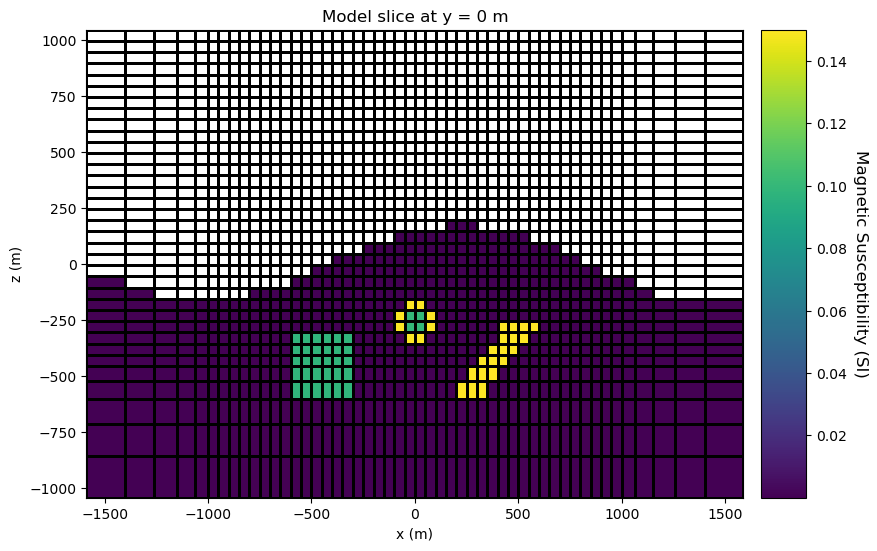

In [202]:
fig = plt.figure(figsize=(9, 6))
#Modelo gerado 
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()

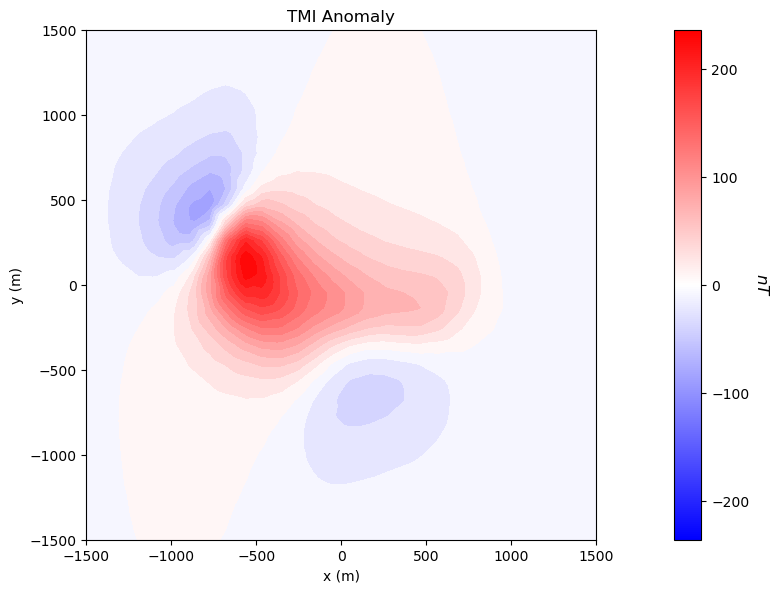

In [203]:
###################################################################
# Simulation: TMI Data for a Susceptibility Model
# -----------------------------------------------
#
# Here we demonstrate how to predict magnetic data for a magnetic
# susceptibility model using the integral formulation.
#

# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for a susceptibility model
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(9, 6))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()
# tempo do ultimo processamento 8m53s
# tempo do ultimo processamento 70m37s

In [204]:

# if write_output:
#     dir_path = os.path.dirname(__file__).split(os.path.sep)
#     dir_path.extend(["outputs"]) #cria a pasta
#     dir_path = os.path.sep.join(dir_path) + os.path.sep

#     if not os.path.exists(dir_path):
#         os.mkdir(dir_path)

#     fname = dir_path + "magnetics_topo.XYZ"
#     np.savetxt(fname, np.c_[xyz_topo], fmt="%.4e")

#     np.random.seed(211)
#     column_names = ['X', 'Y', 'Z', 'Susceptibility']
#     maximum_anomaly = np.max(np.abs(dpred))
#     noise = 0.02 * maximum_anomaly * np.random.randn(len(dpred))
#     fname = dir_path + "magnetics_data.XYZ"
#     np.savetxt(fname, np.c_[receiver_locations, dpred], delimiter='\t', header='\t'.join(column_names), fmt="%.4e")
#     #np.savetxt(fname, np.c_[receiver_locations, dpred + noise], delimiter='\t', header='\t'.join(column_names), fmt="%.4e")
write_output = False

if write_output:
    dir_path = os.path.dirname("E:\Mestrado UFPA (PESQUISA)\SIMPEG\simpeg-main\Modelagens_Mestrado").split(os.path.sep)
    dir_path.extend(["outputs2"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    fname = dir_path + "magnetics_topo_VII.XYZ"
    np.savetxt(fname, np.c_[xyz_topo], fmt="%.4e")

    np.random.seed(211)
    maximum_anomaly = np.max(np.abs(dpred))
    noise = 0.02 * maximum_anomaly * np.random.randn(len(dpred))
    fname = dir_path + "magnetics_data_VII.XYZ"
    np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")